# Group 006-26 Project Report
#### Linda Han, Shaqed Orr, Eric Zhang, Prabhjot Singh

## Introduction:
There are a number of different factors that are attributed to different species of iris flowers. Our multivariable dataset provides information on sepal length, sepal width, petal length, and petal width, that we can use to predict the particular species of flower.


We want to predict the species of an iris flower given its:
1. sepal length in cm 
2. sepal width in cm
3. petal length in cm
4. petal width in cm


We will be using the Iris data set found on https://archive.ics.uci.edu/ml/datasets/iris. This set contains 3 classes of 50 instances each, where each class refers to a species of iris plant. The species are Iris Setosa, Iris Versicolour, and Iris Virginica


## Preliminary data analysis:
First, we load in all the necessary libraries.

In [15]:
library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6) # this lists only 6 rows when we try to display the dataset

#### Reading and cleaning the data

1) We read the `iris` dataset from the original source on the web (UCI Machine Learning Repository) using `read_csv` function

2) We added column names to reflect each of the attributes and mutated the `class` column such that it becomes a factor using `as_factor()`. 

We can now say that our dataset is **tidy** as there is a single iris observation on every row, each column is a single variable (either a measurement of the iris flower or the class it belongs to), and each cell holds a single value.


In [16]:
iris_col <- c("sepal_length_cm", "sepal_width_cm", "petal_length_cm", "petal_width_cm", "class")
iris <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", col_names= iris_col) %>% 
        mutate(class = as_factor(class))

iris

Parsed with column specification:
cols(
  sepal_length_cm = col_double(),
  sepal_width_cm = col_double(),
  petal_length_cm = col_double(),
  petal_width_cm = col_double(),
  class = col_character()
)



sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
⋮,⋮,⋮,⋮,⋮
6.5,3.0,5.2,2.0,Iris-virginica
6.2,3.4,5.4,2.3,Iris-virginica
5.9,3.0,5.1,1.8,Iris-virginica


<br>

#### Splitting the Data

In order to ensure the reproducibility of our results, we use the `set.seed()` function with a randomly chosen initial value. 

There are 150 observations in total and we see from `table 0.1` below that there are 50 observations from each iris class. 

In [59]:
# Summarizes the number of observations in each class 
# (Iris-setosa, Iris-veriscolor, or Iris-virginica)
count <- iris %>%
        count(class)

'Table 0.1'
count

[1] "Table 0.1"

class,n
<fct>,<int>
Iris-setosa,50
Iris-versicolor,50
Iris-virginica,50


Since the proportion of each class is equally represented and the data size isn't large, we choose to partition the data into a training (80%) and testing set (20%) using functions from the `tidymodels` package. 

In [43]:
set.seed(777)

iris_split <- initial_split(iris, prop = 0.80, strata = class)
iris_train <- training(iris_split)
iris_test <- testing(iris_split)

<br>

#### Summary of the training data

Using only the training data, we summarize the data into 2 tables and count the number of rows with missing values to check that all of our rows have values.

1. A summary of the average value of each column using `summarize()` and `across()` 

In [58]:
iris_avg_size <- iris_train %>%
        summarize(across(sepal_length_cm:petal_width_cm, mean))

'Table 1.1'
iris_avg_size

[1] "Table 1.1"

sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm
<dbl>,<dbl>,<dbl>,<dbl>
5.854472,3.06748,3.771545,1.198374


<br>

2. A summary of the number of observations in each class (Iris-setosa, Iris-veriscolor, or Iris-virginica)

In [60]:
iris_class_count <- iris_train %>%
        count(class)

'Table 1.2'
iris_class_count

[1] "Table 1.2"

class,n
<fct>,<int>
Iris-setosa,41
Iris-versicolor,41
Iris-virginica,41


<br>

3. A count of the number of missing rows

In [62]:
sum(is.na(iris_train))

[1] 0

<br>

#### Visualization of the training data

Using only training data, we conduct an exploratory data analysis by visualizing the data with two scatterplots.

For the first graph, we use `ggplot()` to plot the predictors `sepal_width_cm` on the y-axis against `sepal_length_cm` on the x-axis. We also set `colour = "Class"` to mark each observation according to their class.

To improve readability, we use the `options()` and `theme()` functions to modify the size of the plot and labels

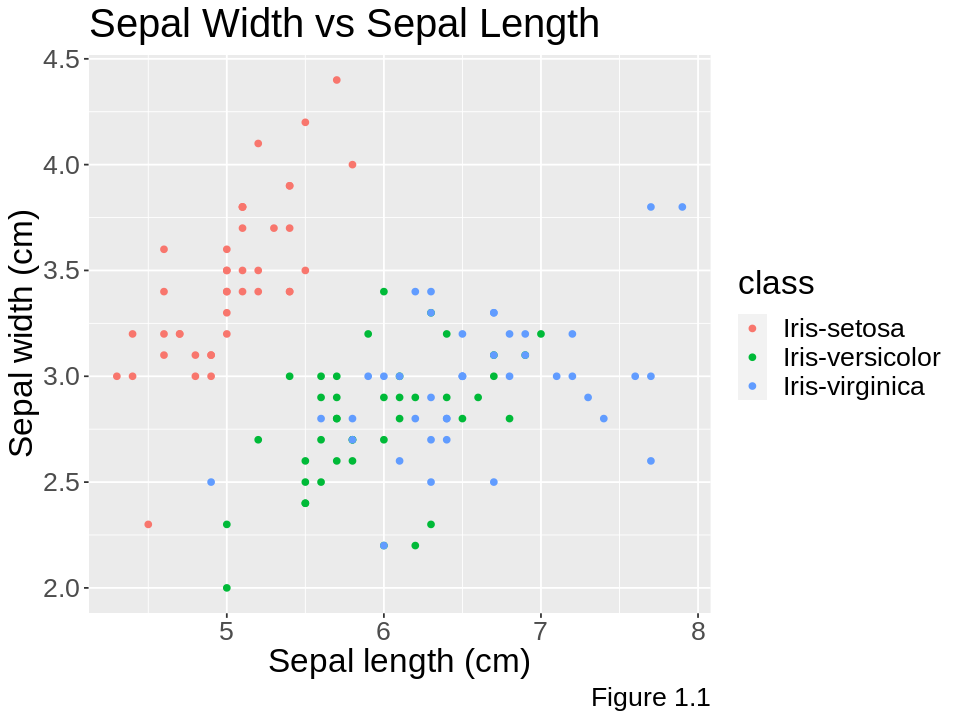

In [71]:
# Graph 1
options(repr.plot.width = 8, repr.plot.height = 6)

iris_plot_sepal <- ggplot(data = iris_train, 
                          aes(x = sepal_length_cm, y = sepal_width_cm , colour = class )) +
                geom_point() +
                labs(x = "Sepal length (cm)", y = "Sepal width (cm)",
                     colour = "Class", caption = "Figure 1.1") +
                ggtitle("Sepal Width vs Sepal Length") +
                theme(text = element_text(size = 20))

iris_plot_sepal

<br>

For the second graph, we repeat the same things we did for graph 1 and change the 

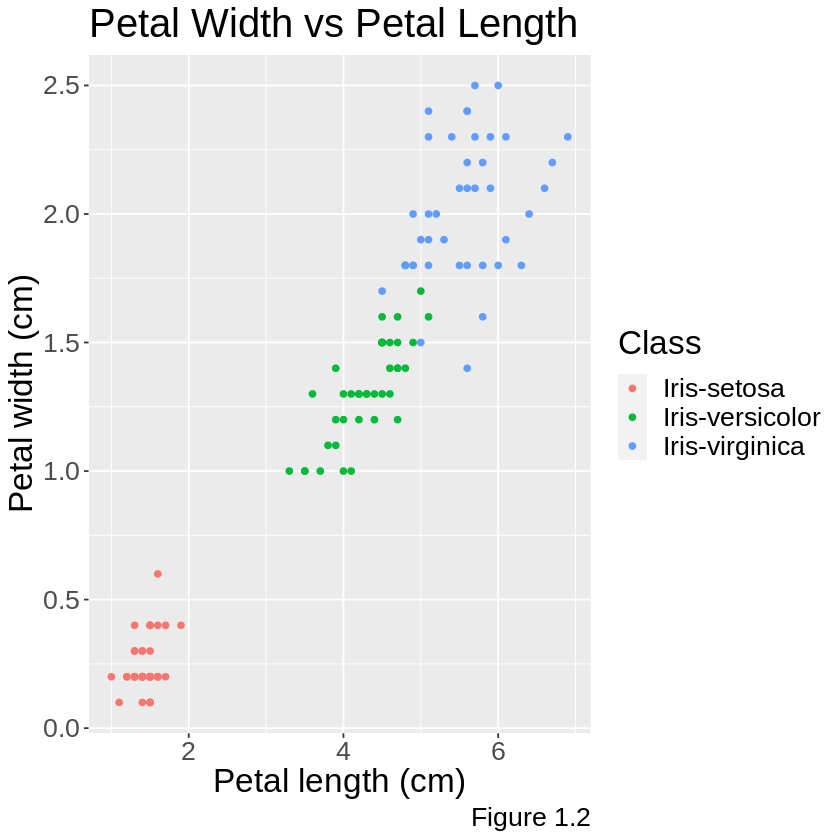

In [65]:
# Graph 2
iris_plot_petal <- ggplot(data = iris_train,
                          aes(x = petal_length_cm, y = petal_width_cm , colour = class )) +
                    geom_point() +
                    labs(x = "Petal length (cm)", y = "Petal width (cm)",
                         colour = "Class", caption = "Figure 1.2") +
                    ggtitle("Petal Width vs Petal Length") +
                    theme(text = element_text(size = 20))

iris_plot_petal

## Building The K-Nearest Neighbour Classifier

### Model Training Phase 

----------------------------

#### 1. Recipe 

Scale and center all predictors (is it needed? since they are have same unit (cm))

In [21]:
iris_recipe <- recipe(class ~ ., data = iris_train) %>% 
            step_center(all_predictors()) %>% 
            step_scale(all_predictors()) 

iris_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Centering for all_predictors()
Scaling for all_predictors()

<br>

To visualize the scaled iris_train data, we use prep and bake functions

In [22]:
iris_scaled <- iris_recipe %>% 
                prep() %>% 
                bake(iris_train)

iris_scaled

sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-1.157990,-0.15110630,-1.329810,-1.308899,Iris-setosa
-1.400635,0.29675092,-1.385883,-1.308899,Iris-setosa
-1.521958,0.07282231,-1.273736,-1.308899,Iris-setosa
⋮,⋮,⋮,⋮,⋮
0.78317214,-0.1511063,0.8009859,1.0509564,Iris-virginica
0.41920423,0.7446081,0.9131331,1.4442657,Iris-virginica
0.05523632,-0.1511063,0.7449123,0.7887503,Iris-virginica


#### 2. Model Specification

We create a nearest neighbour model

In [23]:
iris_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
            set_engine("kknn") %>% 
            set_mode("classification")

iris_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


#### 3. vfold

We chose 5 folds because... TODO

In [24]:
iris_vfold <- vfold_cv(iris_train, v = 5, strata = class)

#### 4. Workflow

In [25]:
k_vals <- tibble(neighbors = seq(from=1, to=20, by=1))

In [26]:
iris_tune_workflow <- workflow() %>% 
    add_recipe(iris_recipe) %>% 
    add_model(iris_spec) %>% 
    tune_grid(resamples = iris_vfold, grid = k_vals)

#### 5. Collect Metrics

In [33]:
iris_metrics_tune <- iris_tune_workflow %>% 
    collect_metrics() %>% 
    filter(.metric == "accuracy") %>% 
    arrange(desc(mean))

iris_metrics_tune

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,multiclass,0.9685185,5,0.0141488,Model07
8,accuracy,multiclass,0.9685185,5,0.0141488,Model08
9,accuracy,multiclass,0.9685185,5,0.0141488,Model09
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,accuracy,multiclass,0.9435185,5,0.016064214,Model02
19,accuracy,multiclass,0.9435185,5,0.009189552,Model19
20,accuracy,multiclass,0.9435185,5,0.009189552,Model20


#### 6. Plot Neighbors vs Accuracy Graph

We use `scale_x_continuous()` to adjust the x-axis

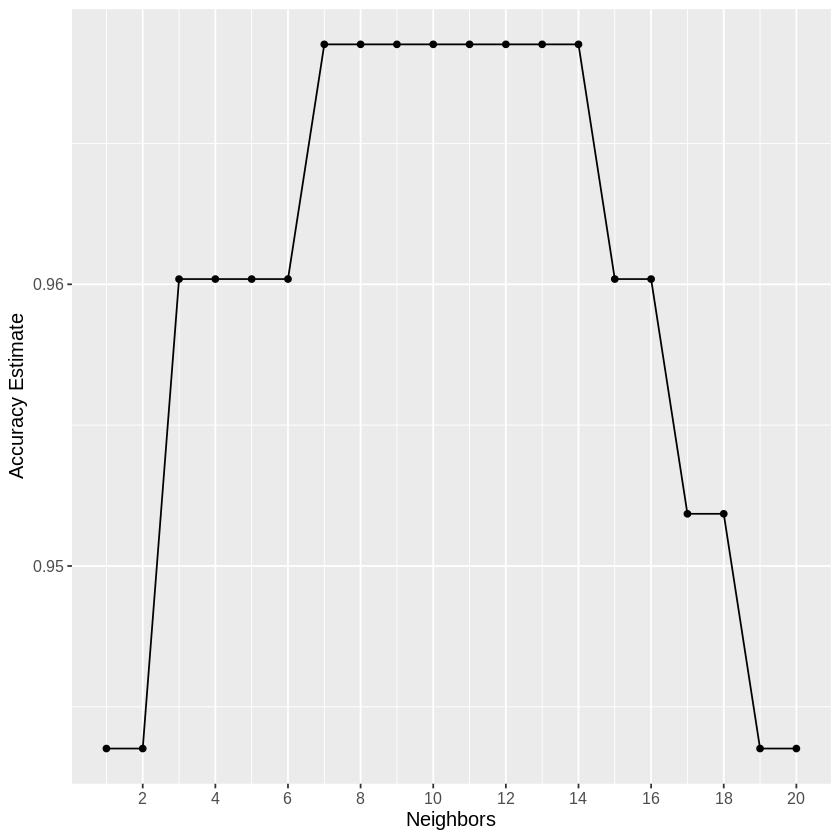

In [70]:
neighbors_plot <- ggplot(iris_metrics_tune, aes(x=neighbors, y=mean)) + 
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12)) +
    scale_x_continuous(breaks = seq(0, 25, by = 2))

neighbors_plot

#### We find that the optimal $K$ is 7

#### 7. Rebuild Model Specification and Workflow with $K$ = 7

In [38]:
iris_spec_optimal <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) %>% 
            set_engine("kknn") %>% 
            set_mode("classification")

iris_spec_optimal

iris_fit <- workflow() %>% 
    add_recipe(iris_recipe) %>% 
    add_model(iris_spec_optimal) %>% 
    fit(iris_train)

iris_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 7
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_center()
● step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~7, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.03252033
Best kernel: rectangular
Best k: 7

<br> 

### Model Testing Phase

------------------------

#### 1. Predict

In [39]:
iris_test_predictions <- predict(iris_fit, iris_test) %>% 
    bind_cols(iris_test)

iris_test_predictions

.pred_class,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Iris-setosa,5.1,3.5,1.4,0.2,Iris-setosa
Iris-setosa,4.4,2.9,1.4,0.2,Iris-setosa
Iris-setosa,4.9,3.1,1.5,0.1,Iris-setosa
⋮,⋮,⋮,⋮,⋮,⋮
Iris-virginica,6.4,3.1,5.5,1.8,Iris-virginica
Iris-virginica,6.9,3.1,5.4,2.1,Iris-virginica
Iris-virginica,6.7,3.0,5.2,2.3,Iris-virginica


#### 2. Assess accuracy of predictions

In [41]:
iris_metrics_final <- iris_test_predictions %>% 
    metrics(truth = class, estimate = .pred_class)

iris_conf_mat <- iris_test_predictions %>% 
    conf_mat(truth = class, estimate = .pred_class)

iris_metrics_final
iris_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9629630
kap,multiclass,0.9444444


                 Truth
Prediction        Iris-setosa Iris-versicolor Iris-virginica
  Iris-setosa               9               0              0
  Iris-versicolor           0               9              1
  Iris-virginica            0               0              8

<br>

## Methods:

We will be splitting our data into 80% for training and 20% for the testing set. We will use the $K$-Nearest Neighbor method and tidymodels library functions to train our data. We will also perform cross-validation with 5 folds for finding the optimal $K$ value. Since we only have 4 variables(i.e. sepal length,sepal width, petal length,petal width) and all of them depict crucial measurements of the flower, we will be using them all for data analysis.

We plan to visualize the results using...
1. A confusion matrix
2. A scatterplot graph with coloured decision regions